In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

sys.path.insert(0,'/global/homes/b/bpb/repos/envnet/envnet/use')
import analysis_tools as at

INFO:rdkit:Enabling RDKit 2023.09.1 jupyter extensions


In [2]:
import os
from IPython import get_ipython
from pathlib import Path

def get_notebook_dir():
    ipython = get_ipython()
    if ipython:
        notebook_dir = ipython.starting_dir
        return notebook_dir
    else:
        return os.getcwd()

module_path = os.path.join(Path(get_notebook_dir()).parents[1])


G = nx.read_graphml(os.path.join(module_path, 'data/envnet.graphml'))

# write G to graphml
# nx.write_graphml(G,os.path.join(module_path, 'data/envnet.graphml'))




In [3]:
node_data = at.graph_to_df()


In [4]:

node_data['inchi_key_identity'].nunique(),sum(pd.notna(node_data['class_results_propagated'])),sum(pd.notna(node_data['class_results'])),sum(pd.notna(node_data['inchi_key_identity'])),sum(pd.notna(node_data['inchi_key_identity']) & pd.notna(node_data['class_results_propagated'])),sum(pd.notna(node_data['inchi_key_identity']) & pd.notna(node_data['class_results']))

(681, 5811, 653, 759, 690, 653)

In [5]:
node_data = at.graph_to_df()
cols = ['node_id','class_results','class_results_propagated']
node_data = node_data[cols]
node_data['node_id'] = node_data['node_id'].astype(str)
node_data.set_index('node_id',inplace=True)
node_data

,class_results,class_results_propagated
node_id,,
9.0,NaN,NaN
3060.0,NaN,Simple coumarins
13.0,NaN,Dicarboxylic acids
85.0,NaN,Dicarboxylic acids
15.0,NaN,NaN
...,...,...
16111.0,NaN,NaN
16114.0,NaN,NaN
16117.0,NaN,NaN


In [6]:
# assign colors to the top 10 class_results and the top 10 class_results_propagated
top_classes_propagated = node_data['class_results_propagated'].value_counts().index[:10]

# setup colormap for top 10
import matplotlib.colors as mcolors
import matplotlib.cm as cm
colors = cm.tab10.colors
colors = [mcolors.to_hex(c) for c in colors]
top_class_colors_propagated = dict(zip(top_classes_propagated,colors))

# put this information back in node_data
node_data['color_compound_class'] = node_data['class_results'].map(top_class_colors_propagated)
node_data['color_compound_class_propagated'] = node_data['class_results_propagated'].map(top_class_colors_propagated)
# fill in grey for missing values as hex code
node_data['color_compound_class'] = node_data['color_compound_class'].fillna('#FFFFFF')
node_data['color_compound_class_propagated'] = node_data['color_compound_class_propagated'].fillna('#FFFFFF')
# add color_compound_class and color_compound_class_propagated to the graph
nx.set_node_attributes(G,node_data['color_compound_class'].to_dict(),'color_compound_class')
nx.set_node_attributes(G,node_data['color_compound_class_propagated'].to_dict(),'color_compound_class_propagated')

# write the network back to graphml
nx.write_graphml(G,os.path.join(module_path, 'data/envnet.graphml'))

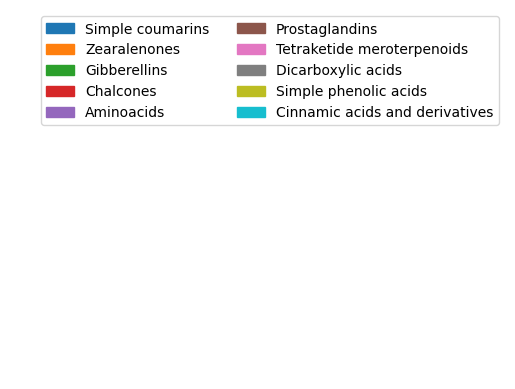

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def make_class_legend(top_class_colors,save_file=None):
    # Create a legend for the colors, use two columns for the top 10
    fig, ax = plt.subplots()
    patches = []
    for class_name,color in top_class_colors.items():
        patches.append(mpatches.Patch(color=color, label=class_name))
    plt.legend(handles=patches,ncol=2)
    plt.axis('off')
    if save_file:
        plt.savefig(save_file)
    plt.show()
make_class_legend(top_class_colors_propagated,os.path.join(module_path, 'data/compound_class_legend.pdf'))

In [11]:
node_data[(~node_data['color_compound_class'].str.contains('#FFFFFF'))].sample(20)

,class_results,class_results_propagated,color_compound_class,color_compound_class_propagated
node_id,,,,
8503.0,Prostaglandins,Prostaglandins,#8c564b,#8c564b
2658.0,Simple coumarins,Simple coumarins,#1f77b4,#1f77b4
1126.0,Simple phenolic acids,Simple phenolic acids,#bcbd22,#bcbd22
1073.0,Aminoacids,Aminoacids,#9467bd,#9467bd
5439.0,Aminoacids,Aminoacids,#9467bd,#9467bd
598.0,Cinnamic acids and derivatives,Cinnamic acids and derivatives,#17becf,#17becf
8693.0,Prostaglandins,Prostaglandins,#8c564b,#8c564b
4944.0,Aminoacids,Aminoacids,#9467bd,#9467bd
9693.0,Prostaglandins,Prostaglandins,#8c564b,#8c564b
